In [1]:
import os
import subprocess
import pandas as pd
import platform
import pathlib
import numpy as np
from annotations import *
from extract_video_features import *
from extract_audio_features import *
import cv2
import seaborn as sns

from tqdm import tqdm


In [2]:
#get current directory
cwd = os.getcwd()

In [3]:
cwd

'/Users/valentinadiproietto/filrouge'

In [4]:
OpenFace_folder = '/Users/valentinadiproietto/OpenFace'
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'

In [5]:
Video_folder = '/Users/valentinadiproietto/Desktop/video_stress'

In [6]:
video_paths, video_names = get_videos(Video_folder)

In [7]:
video_names

['WIN_20210331_21_22_52_Pro',
 'WIN_20210329_14_13_45_Pro',
 'WIN_20210406_18_49_10_Pro',
 'WIN_20210408_14_11_32_Pro',
 'WIN_20210408_15_20_51_Pro',
 'WIN_20210404_10_58_27_Pro',
 'WIN_20210414_06_24_52_Pro',
 'WIN_20210406_15_06_15_Pro',
 'WIN_20210417_14_53_12_Pro',
 'WIN_20210413_15_38_01_Pro',
 'WIN_20210408_11_48_58_Pro',
 'WIN_20210408_16_04_32_Pro',
 'WIN_20210329_10_16_02_Pro',
 'WIN_20210323_19_17_40_Pro',
 'WIN_20210409_10_26_11_Pro',
 'Test_pour_AFPA',
 'WIN_20210405_15_09_16_Pro',
 'WIN_20210407_14_54_56_Pro_edit2',
 'WIN_20210406_21_05_52_Pro',
 'WIN_20210403_18_49_15_Pro',
 'WIN_20210408_14_02_19_Pro',
 'WIN_20210415_15_41_24_Pro',
 'WIN_20210406_18_35_52_Pro',
 'WIN_20210402_14_27_50_Pro',
 'WIN_20210407_09_04_05_Pro',
 'WIN_20210402_19_04_53_Pro',
 'WIN_20210416_08_06_54_Pro',
 'Video_1',
 'WIN_20210408_14_00_44_Pro',
 'WIN_20210404_21_41_12_Pro',
 'WIN_20210330_13_10_29_Pro']

In [8]:
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210402_14_27_50_Pro')

	

In [9]:
len(video_names)

29

In [10]:
list_df_max = []
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations('/Users/valentinadiproietto/OpenFace/processed/', v_name, filename_annotations, "max")
    list_df_max.append(eliminate_features(df_annoted))


    

100%|██████████| 29/29 [01:46<00:00,  3.66s/it]


## WITH MAX AS AGRREGATOR



In [11]:
to_drop = ['frame','face_id','timestamp','confidence','success']

list_df_with_dist_max = []
for i in tqdm(list_df_max):
    l=add_dist_features(i)
    #l=l[l['success']!=0]
    l.drop(to_drop, axis='columns', inplace=True)
    list_df_with_dist_max.append(l)

    

100%|██████████| 29/29 [03:32<00:00,  7.31s/it]


In [21]:
groupby_features = ['video_name','stress_global','stress','diapo','type_candidat','sexe','dist_head',  'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x',
       'dist_pose_y', 'dist_pose_z']

df = pd.concat(list_df_with_dist_max)
df = df.groupby(groupby_features).agg(['mean', 'std']).reset_index()
df.columns= df.columns.map('_'.join).str.strip('_')


In [25]:
df.columns

Index(['video_name', 'stress_global', 'stress', 'diapo', 'type_candidat',
       'sexe', 'dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x',
       'dist_pose_y', 'dist_pose_z', 'AU01_r_mean', 'AU01_r_std',
       'AU02_r_mean', 'AU02_r_std', 'AU04_r_mean', 'AU04_r_std', 'AU05_r_mean',
       'AU05_r_std', 'AU06_r_mean', 'AU06_r_std', 'AU07_r_mean', 'AU07_r_std',
       'AU09_r_mean', 'AU09_r_std', 'AU10_r_mean', 'AU10_r_std', 'AU12_r_mean',
       'AU12_r_std', 'AU14_r_mean', 'AU14_r_std', 'AU15_r_mean', 'AU15_r_std',
       'AU17_r_mean', 'AU17_r_std', 'AU20_r_mean', 'AU20_r_std', 'AU23_r_mean',
       'AU23_r_std', 'AU25_r_mean', 'AU25_r_std', 'AU26_r_mean', 'AU26_r_std',
       'AU45_r_mean', 'AU45_r_std', 'AU01_c_mean', 'AU01_c_std', 'AU02_c_mean',
       'AU02_c_std', 'AU04_c_mean', 'AU04_c_std', 'AU05_c_mean', 'AU05_c_std',
       'AU06_c_mean', 'AU06_c_std', 'AU07_c_mean', 'AU07_c_std', 'AU09_c_mean',
       'AU09_c_std', 'AU10_c_mean', 'AU10_c_std', 'AU12_c_mean', 'AU12_

## TOUTES LES FEATURES


In [22]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat'],axis=1)

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [23]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)


print(f'RMSE={rmse}')


RMSE=0.7602800236003274


## SANS AU_r


In [26]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat', 'AU01_r_mean', 'AU01_r_std',
       'AU02_r_mean', 'AU02_r_std', 'AU04_r_mean', 'AU04_r_std', 'AU05_r_mean',
       'AU05_r_std', 'AU06_r_mean', 'AU06_r_std', 'AU07_r_mean', 'AU07_r_std',
       'AU09_r_mean', 'AU09_r_std', 'AU10_r_mean', 'AU10_r_std', 'AU12_r_mean',
       'AU12_r_std', 'AU14_r_mean', 'AU14_r_std', 'AU15_r_mean', 'AU15_r_std',
       'AU17_r_mean', 'AU17_r_std', 'AU20_r_mean', 'AU20_r_std', 'AU23_r_mean',
       'AU23_r_std', 'AU25_r_mean', 'AU25_r_std', 'AU26_r_mean', 'AU26_r_std',
       'AU45_r_mean', 'AU45_r_std'],axis=1)

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [27]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)


print(f'RMSE={rmse}')

RMSE=0.7430420099640589


## SANS AU_c

In [28]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat', 'AU01_c_mean', 'AU01_c_std', 'AU02_c_mean',
       'AU02_c_std', 'AU04_c_mean', 'AU04_c_std', 'AU05_c_mean', 'AU05_c_std',
       'AU06_c_mean', 'AU06_c_std', 'AU07_c_mean', 'AU07_c_std', 'AU09_c_mean',
       'AU09_c_std', 'AU10_c_mean', 'AU10_c_std', 'AU12_c_mean', 'AU12_c_std',
       'AU14_c_mean', 'AU14_c_std', 'AU15_c_mean', 'AU15_c_std', 'AU17_c_mean',
       'AU17_c_std', 'AU20_c_mean', 'AU20_c_std', 'AU23_c_mean', 'AU23_c_std',
       'AU25_c_mean', 'AU25_c_std', 'AU26_c_mean', 'AU26_c_std', 'AU28_c_mean',
       'AU28_c_std', 'AU45_c_mean', 'AU45_c_std'],axis=1)

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [29]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)


print(f'RMSE={rmse}')

RMSE=0.7495036452784697


## SANS DISTANCE

In [30]:
df.columns

Index(['video_name', 'stress_global', 'stress', 'diapo', 'type_candidat',
       'sexe', 'dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x',
       'dist_pose_y', 'dist_pose_z', 'AU01_r_mean', 'AU01_r_std',
       'AU02_r_mean', 'AU02_r_std', 'AU04_r_mean', 'AU04_r_std', 'AU05_r_mean',
       'AU05_r_std', 'AU06_r_mean', 'AU06_r_std', 'AU07_r_mean', 'AU07_r_std',
       'AU09_r_mean', 'AU09_r_std', 'AU10_r_mean', 'AU10_r_std', 'AU12_r_mean',
       'AU12_r_std', 'AU14_r_mean', 'AU14_r_std', 'AU15_r_mean', 'AU15_r_std',
       'AU17_r_mean', 'AU17_r_std', 'AU20_r_mean', 'AU20_r_std', 'AU23_r_mean',
       'AU23_r_std', 'AU25_r_mean', 'AU25_r_std', 'AU26_r_mean', 'AU26_r_std',
       'AU45_r_mean', 'AU45_r_std', 'AU01_c_mean', 'AU01_c_std', 'AU02_c_mean',
       'AU02_c_std', 'AU04_c_mean', 'AU04_c_std', 'AU05_c_mean', 'AU05_c_std',
       'AU06_c_mean', 'AU06_c_std', 'AU07_c_mean', 'AU07_c_std', 'AU09_c_mean',
       'AU09_c_std', 'AU10_c_mean', 'AU10_c_std', 'AU12_c_mean', 'AU12_

In [31]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat', 'dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x',
       'dist_pose_y', 'dist_pose_z'],axis=1)

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [32]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)


print(f'RMSE={rmse}')

RMSE=0.7592392809347299


## SANS SEXE



In [33]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat', 'sexe'],axis=1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [34]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)


print(f'RMSE={rmse}')

RMSE=0.7644306938593489


In [35]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


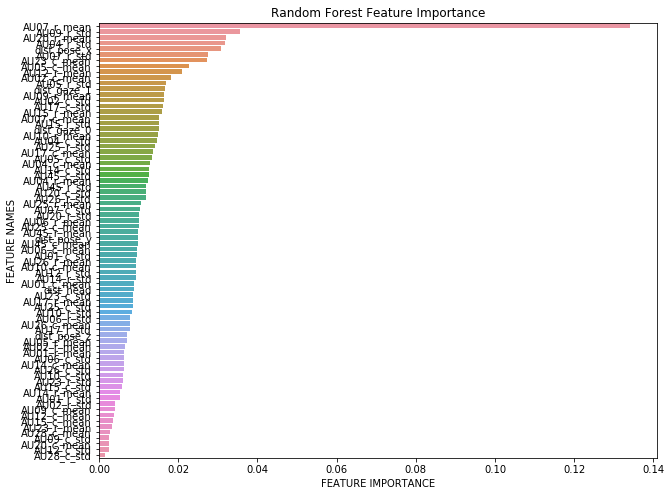

In [36]:
plot_feature_importance(model.feature_importances_,x_train.columns,'Random Forest') 

## WITHOUT DISTANCES

In [18]:
groupby_features = ['video_name','stress_global','stress','diapo','type_candidat','sexe' ]

df = pd.concat(list_df)
df= df.drop(['gaze_0_x','gaze_0_y',	'gaze_0_z',	'gaze_1_x', 'gaze_1_y','gaze_1_z','gaze_angle_x', 'gaze_angle_y', 'pose_Tx','pose_Ty','pose_Tz','pose_Rx', 'pose_Ry', 	'pose_Rz'], axis=1)
df = df.groupby(groupby_features).mean().reset_index()
df

,video_name,stress_global,stress,diapo,type_candidat,sexe,frame,face_id,timestamp,confidence,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,Video_1,1,0,8,nan,F,4027.0,0.0,135.011637,0.977619,...,0.000000,0.055667,0.013414,0.145540,0.167002,0.407780,0.765258,0.774648,0.000000,0.298457
1,Video_1,1,0,9,nan,F,6248.5,0.0,209.509488,0.975647,...,0.004404,0.062331,0.008130,0.069444,0.246951,0.178862,0.741531,0.740854,0.001694,0.139566
2,Video_1,1,1,1,nan,F,1641.0,0.0,54.997289,0.980000,...,0.000000,0.457482,0.365133,0.050899,0.095093,0.500457,0.031698,0.007924,0.000000,0.372447
3,Video_1,1,1,10,nan,F,8723.5,0.0,292.508445,0.976672,...,0.000000,0.136637,0.052553,0.108108,0.108108,0.512513,0.751251,0.683684,0.000000,0.233233
4,Video_1,1,1,11,nan,F,11153.5,0.0,373.998331,0.973868,...,0.000000,0.227463,0.125087,0.112509,0.116352,0.357442,0.462963,0.635919,0.015024,0.185185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,WIN_20210417_14_53_12_Pro,0,0,10,Stagiaire,F,5762.0,0.0,191.501484,0.979752,...,0.002978,0.019355,0.173201,0.174690,0.129032,0.933499,0.145409,0.132506,0.000000,0.159305
220,WIN_20210417_14_53_12_Pro,0,0,11,Stagiaire,F,8213.5,0.0,272.991832,0.979931,...,0.001731,0.003809,0.052632,0.049169,0.092452,0.930055,0.131579,0.074792,0.003809,0.168629
221,WIN_20210417_14_53_12_Pro,0,1,12,Stagiaire,F,12079.5,0.0,401.501594,0.962225,...,0.002064,0.018167,0.000000,0.028902,0.218002,0.741949,0.183732,0.107969,0.001032,0.124690
222,WIN_20210417_14_53_12_Pro,0,1,17,Stagiaire,F,14937.5,0.0,496.504413,0.980000,...,0.000000,0.067661,0.108945,0.329128,0.014908,0.994266,0.266055,0.331422,0.049312,0.232798


In [19]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat', 'frame','face_id','timestamp','confidence','success'],axis=1)
x

,sexe,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,F,1.047914,0.342656,0.323394,0.096801,0.369712,0.833548,0.018115,1.190309,0.036097,...,0.000000,0.055667,0.013414,0.145540,0.167002,0.407780,0.765258,0.774648,0.000000,0.298457
1,F,0.947530,0.170640,0.054759,0.138577,0.290220,0.876741,0.000715,1.221988,0.086501,...,0.004404,0.062331,0.008130,0.069444,0.246951,0.178862,0.741531,0.740854,0.001694,0.139566
2,F,0.003398,0.000439,0.666589,0.011064,0.221801,0.584916,0.195983,0.653590,0.005459,...,0.000000,0.457482,0.365133,0.050899,0.095093,0.500457,0.031698,0.007924,0.000000,0.372447
3,F,1.015721,0.425821,0.079680,0.143624,0.274910,0.738799,0.003939,1.281166,0.091116,...,0.000000,0.136637,0.052553,0.108108,0.108108,0.512513,0.751251,0.683684,0.000000,0.233233
4,F,0.871932,0.320461,0.083491,0.251726,0.382746,0.561709,0.021618,1.191359,0.088847,...,0.000000,0.227463,0.125087,0.112509,0.116352,0.357442,0.462963,0.635919,0.015024,0.185185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,F,0.305747,0.195752,0.218913,0.037692,0.222918,0.720764,0.044988,1.096690,0.011141,...,0.002978,0.019355,0.173201,0.174690,0.129032,0.933499,0.145409,0.132506,0.000000,0.159305
220,F,0.203982,0.097375,0.292386,0.051499,0.321697,0.989041,0.037517,0.838473,0.008449,...,0.001731,0.003809,0.052632,0.049169,0.092452,0.930055,0.131579,0.074792,0.003809,0.168629
221,F,0.356883,0.061600,0.395706,0.011831,0.277116,0.988301,0.078976,0.252054,0.001693,...,0.002064,0.018167,0.000000,0.028902,0.218002,0.741949,0.183732,0.107969,0.001032,0.124690
222,F,0.104461,0.011571,0.638750,0.054232,0.365562,1.489920,0.010138,0.783991,0.000000,...,0.000000,0.067661,0.108945,0.329128,0.014908,0.994266,0.266055,0.331422,0.049312,0.232798


In [20]:

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
print(f'RMSE={rmse}')
print(f'MSE={mse}')

RMSE=0.7376433061167325
MSE=0.5441176470588235


In [21]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
print(f'RMSE={rmse}')
print(f'MSE={mse}')

RMSE=0.6992653708167803
MSE=0.48897205882352934


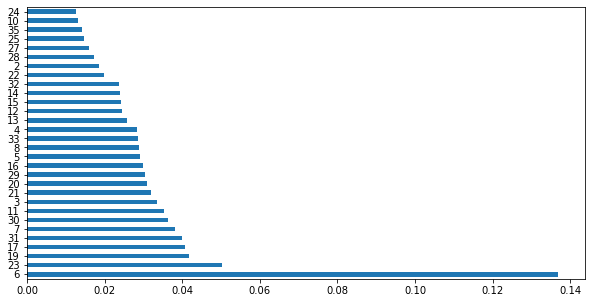

In [22]:

feat_importancesRF = pd.Series(model.feature_importances_)

plt.figure(figsize=(10,5))
feat_importancesRF.nlargest(30).plot(kind='barh');


In [283]:
x.iloc[:,6]

0      0.833548
1      0.876741
2      0.584916
3      0.738799
4      0.561709
         ...   
219    0.720764
220    0.989041
221    0.988301
222    1.489920
223    1.071493
Name: AU07_r, Length: 224, dtype: float64

## PRELIMINARY STUDY OF FEATURES

In [39]:
pd.set_option('display.max_columns', None)
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,eye_lmk_x_28,eye_lmk_x_29,eye_lmk_x_30,eye_lmk_x_31,eye_lmk_x_32,eye_lmk_x_33,eye_lmk_x_34,eye_lmk_x_35,eye_lmk_x_36,eye_lmk_x_37,eye_lmk_x_38,eye_lmk_x_39,eye_lmk_x_40,eye_lmk_x_41,eye_lmk_x_42,eye_lmk_x_43,eye_lmk_x_44,eye_lmk_x_45,eye_lmk_x_46,eye_lmk_x_47,eye_lmk_x_48,eye_lmk_x_49,eye_lmk_x_50,eye_lmk_x_51,eye_lmk_x_52,eye_lmk_x_53,eye_lmk_x_54,eye_lmk_x_55,eye_lmk_y_0,eye_lmk_y_1,eye_lmk_y_2,eye_lmk_y_3,eye_lmk_y_4,eye_lmk_y_5,eye_lmk_y_6,eye_lmk_y_7,eye_lmk_y_8,eye_lmk_y_9,eye_lmk_y_10,eye_lmk_y_11,eye_lmk_y_12,eye_lmk_y_13,eye_lmk_y_14,eye_lmk_y_15,eye_lmk_y_16,eye_lmk_y_17,eye_lmk_y_18,eye_lmk_y_19,eye_lmk_y_20,eye_lmk_y_21,eye_lmk_y_22,eye_lmk_y_23,eye_lmk_y_24,eye_lmk_y_25,eye_lmk_y_26,eye_lmk_y_27,eye_lmk_y_28,eye_lmk_y_29,eye_lmk_y_30,eye_lmk_y_31,eye_lmk_y_32,eye_lmk_y_33,eye_lmk_y_34,eye_lmk_y_35,eye_lmk_y_36,eye_lmk_y_37,eye_lmk_y_38,eye_lmk_y_39,eye_lmk_y_40,eye_lmk_y_41,eye_lmk_y_42,eye_lmk_y_43,eye_lmk_y_44,eye_lmk_y_45,eye_lmk_y_46,eye_lmk_y_47,eye_lmk_y_48,eye_lmk_y_49,eye_lmk_y_50,eye_lmk_y_51,eye_lmk_y_52,eye_lmk_y_53,eye_lmk_y_54,eye_lmk_y_55,eye_lmk_X_0,eye_lmk_X_1,eye_lmk_X_2,eye_lmk_X_3,eye_lmk_X_4,eye_lmk_X_5,eye_lmk_X_6,eye_lmk_X_7,eye_lmk_X_8,eye_lmk_X_9,eye_lmk_X_10,eye_lmk_X_11,eye_lmk_X_12,eye_lmk_X_13,eye_lmk_X_14,eye_lmk_X_15,eye_lmk_X_16,eye_lmk_X_17,eye_lmk_X_18,eye_lmk_X_19,eye_lmk_X_20,eye_lmk_X_21,eye_lmk_X_22,eye_lmk_X_23,eye_lmk_X_24,eye_lmk_X_25,eye_lmk_X_26,eye_lmk_X_27,eye_lmk_X_28,eye_lmk_X_29,eye_lmk_X_30,eye_lmk_X_31,eye_lmk_X_32,eye_lmk_X_33,eye_lmk_X_34,eye_lmk_X_35,eye_lmk_X_36,eye_lmk_X_37,eye_lmk_X_38,eye_lmk_X_39,eye_lmk_X_40,eye_lmk_X_41,eye_lmk_X_42,eye_lmk_X_43,eye_lmk_X_44,eye_lmk_X_45,eye_lmk_X_46,eye_lmk_X_47,eye_lmk_X_48,eye_lmk_X_49,eye_lmk_X_50,eye_lmk_X_51,eye_lmk_X_52,eye_lmk_X_53,eye_lmk_X_54,eye_lmk_X_55,eye_lmk_Y_0,eye_lmk_Y_1,eye_lmk_Y_2,eye_lmk_Y_3,eye_lmk_Y_4,eye_lmk_Y_5,eye_lmk_Y_6,eye_lmk_Y_7,eye_lmk_Y_8,eye_lmk_Y_9,eye_lmk_Y_10,eye_lmk_Y_11,eye_lmk_Y_12,eye_lmk_Y_13,eye_lmk_Y_14,eye_lmk_Y_15,eye_lmk_Y_16,eye_lmk_Y_17,eye_lmk_Y_18,eye_lmk_Y_19,eye_lmk_Y_20,eye_lmk_Y_21,eye_lmk_Y_22,eye_lmk_Y_23,eye_lmk_Y_24,eye_lmk_Y_25,eye_lmk_Y_26,eye_lmk_Y_27,eye_lmk_Y_28,eye_lmk_Y_29,eye_lmk_Y_30,eye_lmk_Y_31,eye_lmk_Y_32,eye_lmk_Y_33,eye_lmk_Y_34,eye_lmk_Y_35,eye_lmk_Y_36,eye_lmk_Y_37,eye_lmk_Y_38,eye_lmk_Y_39,eye_lmk_Y_40,eye_lmk_Y_41,eye_lmk_Y_42,eye_lmk_Y_43,eye_lmk_Y_44,eye_lmk_Y_45,eye_lmk_Y_46,eye_lmk_Y_47,eye_lmk_Y_48,eye_lmk_Y_49,eye_lmk_Y_50,eye_lmk_Y_51,eye_lmk_Y_52,eye_lmk_Y_53,eye_lmk_Y_54,eye_lmk_Y_55,eye_lmk_Z_0,eye_lmk_Z_1,eye_lmk_Z_2,eye_lmk_Z_3,eye_lmk_Z_4,eye_lmk_Z_5,eye_lmk_Z_6,eye_lmk_Z_7,eye_lmk_Z_8,eye_lmk_Z_9,eye_lmk_Z_10,eye_lmk_Z_11,eye_lmk_Z_12,eye_lmk_Z_13,eye_lmk_Z_14,eye_lmk_Z_15,eye_lmk_Z_16,eye_lmk_Z_17,eye_lmk_Z_18,eye_lmk_Z_19,eye_lmk_Z_20,eye_lmk_Z_21,eye_lmk_Z_22,eye_lmk_Z_23,eye_lmk_Z_24,eye_lmk_Z_25,eye_lmk_Z_26,eye_lmk_Z_27,eye_lmk_Z_28,eye_lmk_Z_29,eye_lmk_Z_30,eye_lmk_Z_31,eye_lmk_Z_32,eye_lmk_Z_33,eye_lmk_Z_34,eye_lmk_Z_35,eye_lmk_Z_36,eye_lmk_Z_37,eye_lmk_Z_38,eye_lmk_Z_39,eye_lmk_Z_40,eye_lmk_Z_41,eye_lmk_Z_42,eye_lmk_Z_43,eye_lmk_Z_44,eye_lmk_Z_45,eye_lmk_Z_46,eye_lmk_Z_47,eye_lmk_Z_48,eye_lmk_Z_49,eye_lmk_Z_50,eye_lmk_Z_51,eye_lmk_Z_52,eye_lmk_Z_53,eye_lmk_Z_54,eye_lmk_Z_55,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_4

In [50]:
for df in list_dataframes:
    print(df[df["confidence"]<0.7]["success"].value_counts())

0    226
Name: success, dtype: int64
0    339
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    12
Name: success, dtype: int64
0    118
Name: success, dtype: int64
0    11
Name: success, dtype: int64
0    340
Name: success, dtype: int64
0    35
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    121
Name: success, dtype: int64
0    506
Name: success, dtype: int64
0    15
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    9
Name: success, dtype: int64
0    264
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    22
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    208
Name: success, dtype: int64
0    122
Name: success, dtype: int64
0    5
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    70
Name: success, dtype: int64
0    14279
1       24
Name: success, dtype: int64
Series([], Name: success, dtype: int64)
0    12
Name: success, dtype: int64
Series([], Name

In every dataframe if confidence is less then 0.7, success is always 0. If confidence is between 0.7 and 0.8, there are cases of success. Therefore I think that one can avoid using the confidence column, we can consider that sucess is a goo way to distinguish between cases of success or not. Be carefull, even if success is equal to zero there are many values that are not equal to zero. 

In [51]:
len(list_dataframes)

31

In [52]:
for i in list_dataframes:
    print(check_success(i))
    

98.34157695664824
93.96474986647677
100.0
99.9474444882407
99.22779922779922
99.96171516079633
95.07823613086771
99.87678987678987
100.0
99.51358405504804
98.44551626678135
99.9315399484536
100.0
99.96298428888706
98.88920191572423
100.0
99.88188260948573
100.0
98.7196683331301
99.5310891693035
99.97950399672064
100.0
99.69153483453047
47.2531935317138
100.0
99.9057048561999
100.0
100.0
100.0
99.08576533650982
99.39536601126188


The video "'WIN_20210402_14_27_50_Pro'" is problematic for OpenFace, in less than 50% of the frames OpenFace succeded in detecting a face, but in all the other cases OpenFace was succesful, what do we do with this video, maybe we erase the video?

In [53]:
df[df["success"]==0]

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,eye_lmk_x_28,eye_lmk_x_29,eye_lmk_x_30,eye_lmk_x_31,eye_lmk_x_32,eye_lmk_x_33,eye_lmk_x_34,eye_lmk_x_35,eye_lmk_x_36,eye_lmk_x_37,eye_lmk_x_38,eye_lmk_x_39,eye_lmk_x_40,eye_lmk_x_41,eye_lmk_x_42,eye_lmk_x_43,eye_lmk_x_44,eye_lmk_x_45,eye_lmk_x_46,eye_lmk_x_47,eye_lmk_x_48,eye_lmk_x_49,eye_lmk_x_50,eye_lmk_x_51,eye_lmk_x_52,eye_lmk_x_53,eye_lmk_x_54,eye_lmk_x_55,eye_lmk_y_0,eye_lmk_y_1,eye_lmk_y_2,eye_lmk_y_3,eye_lmk_y_4,eye_lmk_y_5,eye_lmk_y_6,eye_lmk_y_7,eye_lmk_y_8,eye_lmk_y_9,eye_lmk_y_10,eye_lmk_y_11,eye_lmk_y_12,eye_lmk_y_13,eye_lmk_y_14,eye_lmk_y_15,eye_lmk_y_16,eye_lmk_y_17,eye_lmk_y_18,eye_lmk_y_19,eye_lmk_y_20,eye_lmk_y_21,eye_lmk_y_22,eye_lmk_y_23,eye_lmk_y_24,eye_lmk_y_25,eye_lmk_y_26,eye_lmk_y_27,eye_lmk_y_28,eye_lmk_y_29,eye_lmk_y_30,eye_lmk_y_31,eye_lmk_y_32,eye_lmk_y_33,eye_lmk_y_34,eye_lmk_y_35,eye_lmk_y_36,eye_lmk_y_37,eye_lmk_y_38,eye_lmk_y_39,eye_lmk_y_40,eye_lmk_y_41,eye_lmk_y_42,eye_lmk_y_43,eye_lmk_y_44,eye_lmk_y_45,eye_lmk_y_46,eye_lmk_y_47,eye_lmk_y_48,eye_lmk_y_49,eye_lmk_y_50,eye_lmk_y_51,eye_lmk_y_52,eye_lmk_y_53,eye_lmk_y_54,eye_lmk_y_55,eye_lmk_X_0,eye_lmk_X_1,eye_lmk_X_2,eye_lmk_X_3,eye_lmk_X_4,eye_lmk_X_5,eye_lmk_X_6,eye_lmk_X_7,eye_lmk_X_8,eye_lmk_X_9,eye_lmk_X_10,eye_lmk_X_11,eye_lmk_X_12,eye_lmk_X_13,eye_lmk_X_14,eye_lmk_X_15,eye_lmk_X_16,eye_lmk_X_17,eye_lmk_X_18,eye_lmk_X_19,eye_lmk_X_20,eye_lmk_X_21,eye_lmk_X_22,eye_lmk_X_23,eye_lmk_X_24,eye_lmk_X_25,eye_lmk_X_26,eye_lmk_X_27,eye_lmk_X_28,eye_lmk_X_29,eye_lmk_X_30,eye_lmk_X_31,eye_lmk_X_32,eye_lmk_X_33,eye_lmk_X_34,eye_lmk_X_35,eye_lmk_X_36,eye_lmk_X_37,eye_lmk_X_38,eye_lmk_X_39,eye_lmk_X_40,eye_lmk_X_41,eye_lmk_X_42,eye_lmk_X_43,eye_lmk_X_44,eye_lmk_X_45,eye_lmk_X_46,eye_lmk_X_47,eye_lmk_X_48,eye_lmk_X_49,eye_lmk_X_50,eye_lmk_X_51,eye_lmk_X_52,eye_lmk_X_53,eye_lmk_X_54,eye_lmk_X_55,eye_lmk_Y_0,eye_lmk_Y_1,eye_lmk_Y_2,eye_lmk_Y_3,eye_lmk_Y_4,eye_lmk_Y_5,eye_lmk_Y_6,eye_lmk_Y_7,eye_lmk_Y_8,eye_lmk_Y_9,eye_lmk_Y_10,eye_lmk_Y_11,eye_lmk_Y_12,eye_lmk_Y_13,eye_lmk_Y_14,eye_lmk_Y_15,eye_lmk_Y_16,eye_lmk_Y_17,eye_lmk_Y_18,eye_lmk_Y_19,eye_lmk_Y_20,eye_lmk_Y_21,eye_lmk_Y_22,eye_lmk_Y_23,eye_lmk_Y_24,eye_lmk_Y_25,eye_lmk_Y_26,eye_lmk_Y_27,eye_lmk_Y_28,eye_lmk_Y_29,eye_lmk_Y_30,eye_lmk_Y_31,eye_lmk_Y_32,eye_lmk_Y_33,eye_lmk_Y_34,eye_lmk_Y_35,eye_lmk_Y_36,eye_lmk_Y_37,eye_lmk_Y_38,eye_lmk_Y_39,eye_lmk_Y_40,eye_lmk_Y_41,eye_lmk_Y_42,eye_lmk_Y_43,eye_lmk_Y_44,eye_lmk_Y_45,eye_lmk_Y_46,eye_lmk_Y_47,eye_lmk_Y_48,eye_lmk_Y_49,eye_lmk_Y_50,eye_lmk_Y_51,eye_lmk_Y_52,eye_lmk_Y_53,eye_lmk_Y_54,eye_lmk_Y_55,eye_lmk_Z_0,eye_lmk_Z_1,eye_lmk_Z_2,eye_lmk_Z_3,eye_lmk_Z_4,eye_lmk_Z_5,eye_lmk_Z_6,eye_lmk_Z_7,eye_lmk_Z_8,eye_lmk_Z_9,eye_lmk_Z_10,eye_lmk_Z_11,eye_lmk_Z_12,eye_lmk_Z_13,eye_lmk_Z_14,eye_lmk_Z_15,eye_lmk_Z_16,eye_lmk_Z_17,eye_lmk_Z_18,eye_lmk_Z_19,eye_lmk_Z_20,eye_lmk_Z_21,eye_lmk_Z_22,eye_lmk_Z_23,eye_lmk_Z_24,eye_lmk_Z_25,eye_lmk_Z_26,eye_lmk_Z_27,eye_lmk_Z_28,eye_lmk_Z_29,eye_lmk_Z_30,eye_lmk_Z_31,eye_lmk_Z_32,eye_lmk_Z_33,eye_lmk_Z_34,eye_lmk_Z_35,eye_lmk_Z_36,eye_lmk_Z_37,eye_lmk_Z_38,eye_lmk_Z_39,eye_lmk_Z_40,eye_lmk_Z_41,eye_lmk_Z_42,eye_lmk_Z_43,eye_lmk_Z_44,eye_lmk_Z_45,eye_lmk_Z_46,eye_lmk_Z_47,eye_lmk_Z_48,eye_lmk_Z_49,eye_lmk_Z_50,eye_lmk_Z_51,eye_lmk_Z_52,eye_lmk_Z_53,eye_lmk_Z_54,eye_lmk_Z_55,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_4

In [31]:
annotations_file ='/Users/valentinadiproietto/Desktop/video_stress/Videos_Annotations - Template.csv'

In [17]:
add_video_annotations(df, annotations_file, 2, 'WIN_20210331_21_22_52_Pro')

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,video_name,stress_global,stress,diapo
0,1,0,0.000,0.98,1,0.058144,-0.086946,-0.994515,-0.265938,-0.064276,...,1.0,0.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
1,2,0,0.060,0.98,1,0.076459,-0.143412,-0.986705,-0.259332,-0.081572,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
2,3,0,0.120,0.98,1,0.079903,-0.110330,-0.990678,-0.255499,-0.076939,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
3,4,0,0.180,0.98,1,0.117146,-0.106546,-0.987383,-0.247323,-0.062280,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
4,5,0,0.240,0.98,1,0.080384,-0.101181,-0.991615,-0.289122,-0.066332,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13743,13744,0,823.526,0.98,1,-0.273697,-0.041309,-0.960928,-0.439917,0.018487,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13744,13745,0,823.586,0.98,1,-0.268158,-0.050530,-0.962049,-0.418280,0.013013,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13745,13746,0,823.646,0.98,1,-0.237320,-0.039591,-0.970624,-0.385063,0.008704,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13746,13747,0,823.705,0.98,1,-0.253612,-0.047883,-0.966120,-0.353438,0.000489,...,0.0,1.0,1.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18


In [77]:
a,b, c =get_annotations_video(annotations_file, 'WIN_20210331_21_22_52_Pro','max')

In [79]:
print(a,b,c)

141 591 [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]


In [18]:
 get_df_video_with_annotations('/Users/valentinadiproietto/OpenFace/processed/', 'WIN_20210331_21_22_52_Pro', annotations_file)

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,video_name,stress_global,stress,diapo
0,1,0,0.000,0.98,1,0.058144,-0.086946,-0.994515,-0.265938,-0.064276,...,1.0,0.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
1,2,0,0.060,0.98,1,0.076459,-0.143412,-0.986705,-0.259332,-0.081572,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
2,3,0,0.120,0.98,1,0.079903,-0.110330,-0.990678,-0.255499,-0.076939,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
3,4,0,0.180,0.98,1,0.117146,-0.106546,-0.987383,-0.247323,-0.062280,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
4,5,0,0.240,0.98,1,0.080384,-0.101181,-0.991615,-0.289122,-0.066332,...,1.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13743,13744,0,823.526,0.98,1,-0.273697,-0.041309,-0.960928,-0.439917,0.018487,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13744,13745,0,823.586,0.98,1,-0.268158,-0.050530,-0.962049,-0.418280,0.013013,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13745,13746,0,823.646,0.98,1,-0.237320,-0.039591,-0.970624,-0.385063,0.008704,...,0.0,1.0,0.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18
13746,13747,0,823.705,0.98,1,-0.253612,-0.047883,-0.966120,-0.353438,0.000489,...,0.0,1.0,1.0,0.0,0.0,1.0,WIN_20210331_21_22_52_Pro,1,1,18


FROM THE THESIS

Nous avons choisi d’extraire la position et la rotation de la tête,l’intensité et la présence d’unités d’action faciales et la direction du regard résultant en un vecteur de taille 52. Comme différentes vidéos ont différentes fréquences d’images, nous avons décidé de lisser les valeurs avec une fenêtre temporelle de 0,5s et un chevauchement de 0,25s. 

In [24]:
df['AU01_r'].describe()

count    13748.000000
mean         0.326500
std          0.516159
min          0.000000
25%          0.000000
50%          0.020000
75%          0.510000
max          4.090000
Name: AU01_r, dtype: float64

In [27]:
df['AU01_c'].value_counts()

0.0    9978
1.0    3770
Name: AU01_c, dtype: int64

In [ ]:
For a description of the action units see here https://www.cs.cmu.edu/~face/facs.htm. To extract the action units OpenFace uses SVM. 


The columns 'AUXX_c' for XX in  ['01','02', '04', '05', '06', '07', '09', '10','12', '14', '15', '17', '20', '23', '25','26', '28', '45'] contain only 0's and 1's where 1 correspond to the presence of the corresponding AUXX, while 0 represents the absence. The columns 'AUXX_r' for XX in  for XX in  ['01','02', '04', '05', '06', '07', '09', '10','12', '14', '15', '17', '20', '23', '25','26', '45'] represent the intensity from 1 to 5 of the respective AU (with continuous value in between). REMARK: OpenFace does not compute the intesity for AU2 which is the lip suck. 

In [57]:
print(df.loc[df['AU01_c']==0].shape)

df.loc[df['AU01_c']==0].loc[df['AU01_r']!=0]['AU01_r']

(9978, 714)


1        0.01
2        0.04
3        0.04
4        0.03
8        0.01
         ... 
13709    0.04
13710    0.04
13721    0.05
13722    0.05
13723    0.05
Name: AU01_r, Length: 3422, dtype: float64

It is strange, from the above we can see that, even if 'AU01_c'=0, then there are almost one third of 'AU01_r' which are different from 0, why? So even if it is not detected OpenFace measures the intensity? The reason is that we have extracted the features AU in a dynamic way.

In [64]:
count =0
for i in df.columns:
    if i.startswith("AU"):
        count+=1
print(f"There are {count} columns corresponding to AU, {count-count//2} which mesure the intensity and {count//2} that measure if the AU is detected")               



There are 35 columns corresponding to AU, 18 which mesure the intensity and 17 that measure if the AU is detected


In [65]:
extract_video_features(OpenFace_folder, '/Users/valentinadiproietto/Desktop/video_stress/T2.mov')

CompletedProcess(args='build/bin/FeatureExtraction -f /Users/valentinadiproietto/Desktop/video_stress/T2.mov -2Dfp -3Dfp -pdmparams -pose -aus -gaze', returncode=0, stdout='Could not find the HAAR face detector location\nReading the landmark detector/tracker from: build/bin/model/main_ceclm_general.txt\nReading the landmark detector module from: build/bin/model/cen_general.txt\nReading the PDM module from: build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done\nReading the Triangulations module from: build/bin/model/tris_68.txt....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done\nReading part bas

In [66]:
T2= create_dataframe_video('/Users/valentinadiproietto/OpenFace/processed/', 'T2')

In [67]:
T2

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.324171,0.244781,-0.913781,0.256735,0.201875,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,0.075,0.98,1,0.347186,0.158946,-0.924228,0.261119,0.108721,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,0,0.150,0.98,1,0.303126,0.176676,-0.936430,0.267737,0.173383,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,0,0.225,0.98,1,0.220805,0.161280,-0.961891,0.124654,0.192952,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
4,5,0,0.300,0.98,1,0.194246,0.143095,-0.970460,0.068868,0.157785,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,0,5.247,0.98,1,0.426262,0.049787,-0.903229,0.064937,0.029549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,72,0,5.322,0.98,1,0.410672,0.047468,-0.910547,0.218436,0.038879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,73,0,5.397,0.98,1,0.388188,0.089885,-0.917186,0.247111,0.060966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,74,0,5.472,0.98,1,0.338664,0.112290,-0.934183,0.251199,0.090329,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
T2.loc[T2['AU01_c']==0].loc[T2['AU01_r']!=0][['AU01_c', 'AU01_r']]

,AU01_c,AU01_r
1,0.0,0.07
2,0.0,0.07
3,0.0,0.36
4,0.0,0.29
5,0.0,0.29
16,0.0,0.07
17,0.0,0.18
18,0.0,0.21
19,0.0,0.19
20,0.0,0.08


In [71]:

def extract_video_features_static(OpenFace_directory, Video_path):
    '''
    Extract video features (csv) will be located in the 'processed' folder of OpenFace
    
    Parameters
    ----------
    OpenFace_directory : String
    Directory where the file FeatureExtraction can be found
    
    Video_path : String
    Directory where the Video(e.g. mp4) file can be found
    '''
    
    OS = platform.system() #Returns OS name
    os.chdir(f'{OpenFace_directory}') #Move to the OpenFace directory
    
    if OS == 'Windows':
        cmd = f"FeatureExtraction.exe -f {Video_path} -2Dfp -3Dfp -pdmparams -pose -aus -gaze"
        
    elif OS == 'Darwin':
        cmd = f"build/bin/FeatureExtraction -f {Video_path} -2Dfp -3Dfp -pdmparams -pose -aus -gaze -au_static"
        
    elif OS == 'Linux':
        cmd = f"FeatureExtraction -f {Video_path} -2Dfp -3Dfp -pdmparams -pose -aus -gaze"
        
    return subprocess.run(cmd, shell=True, text=True, capture_output=True)

In [73]:
extract_video_features_static(OpenFace_folder, '/Users/valentinadiproietto/Desktop/video_stress/T2.mov')

CompletedProcess(args='build/bin/FeatureExtraction -f /Users/valentinadiproietto/Desktop/video_stress/T2.mov -2Dfp -3Dfp -pdmparams -pose -aus -gaze -au_static', returncode=0, stdout='Could not find the HAAR face detector location\nReading the landmark detector/tracker from: build/bin/model/main_ceclm_general.txt\nReading the landmark detector module from: build/bin/model/cen_general.txt\nReading the PDM module from: build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done\nReading the Triangulations module from: build/bin/model/tris_68.txt....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done\nReadi

In [74]:
T2_static= create_dataframe_video('/Users/valentinadiproietto/OpenFace/processed/', 'T2')

In [75]:
T2_static.loc[T2_static['AU01_c']==0].loc[T2_static['AU01_r']!=0][['AU01_c', 'AU01_r']]

,AU01_c,AU01_r
0,0.0,0.23
8,0.0,0.61
9,0.0,0.38
10,0.0,0.25
11,0.0,0.32
12,0.0,0.27
13,0.0,0.21
14,0.0,0.08
15,0.0,0.12
16,0.0,0.24


They are a little less, but it does not change a lot. So what is the reason? The reason is explained in the github "NOTE that the intensity and presence predictors have been trained separately and on slightly different datasets, this means that the predictions of both might not always be consistent (e.g. the presence model could be predicting AU as not being present, but the intensity model could be predicting its value above 1)."

ABOUT gaze: to extract it uses a Constrained Local Neural Field (CLNF) landmark detector with which it determined the eyes landmarks, and then comput the gaze direction for each eye and the angle. 

gaze_0_x, gaze_0_y, gaze_0_z Eye gaze direction vector in world coordinates for eye 0 (normalized), eye 0 is the leftmost eye in the image (think of it as a ray going from the left eye in the image in the direction of the eye gaze)

gaze_1_x, gaze_1_y, gaze_1_z Eye gaze direction vector in world coordinates for eye 1 (normalized), eye 1 is the rightmost eye in the image (think of it as a ray going from the right eye in the image in the direction of the eye gaze)

gaze_angle_x, gaze_angle_y Eye gaze direction in radians in world coordinates averaged for both eyes and converted into more easy to use format than gaze vectors. If a person is looking left-right this will results in the change of gaze_angle_x (from positive to negative) and, if a person is looking up-down this will result in change of gaze_angle_y (from negative to positive), if a person is looking straight ahead both of the angles will be close to 0 (within measurement error).

eye_lmk_x_0, eye_lmk_x_1,... eye_lmk_x55, eye_lmk_y_1,... eye_lmk_y_55 location of 2D eye region landmarks in pixels. The landmark index can be found below

eye_lmk_X_0, eye_lmk_X_1,... eye_lmk_X55, eye_lmk_Y_0,... eye_lmk_Z_55 location of 3D eye region landmarks in millimeters. The landmark index can be found below


THEREFORE WE CAN TAKE gaze_0_x, gaze_0_y, gaze_0_z, gaze_1_x, gaze_1_y, gaze_1_z, gaze_angle_x, gaze_angle_y

OR EVEN SIMPLER gaze_angle_x, gaze_angle_y, angle averaged over the two eyes

HEAD POSE, this is calculated from the facial landmarks extracted with a  Convolutional Experts Constrained Local Model (CE-CLM) 

pose_Tx, pose_Ty, pose_Tz the location of the head with respect to camera in millimeters (positive Z is away from the camera)

pose_Rx, pose_Ry, pose_Rz Rotation is in radians around X,Y,Z axes with the convention R = Rx \* Ry \* Rz, left-handed positive sign. This can be seen as pitch (Rx), yaw (Ry), and roll (Rz). The rotation is in world coordinates with camera being the origin. x-axis=left-right, z-axis =in-out, y-axis = up-down, the Rx, Rz, Ry represent the angle of rotation with respect to a given axis.

So to see how much the head moves, I think we need both.

The feature that starts with p are parameters used in the  point distribution model (PDM) which is used to detect facial landmark and the position of the face. They are parameters used by the model, so I think we can avoid to use them. The author says "Local parameters (34 non-rigid) are parameters controlling non-rigid face shape, in other words things like facial expression and face shape (long, vs round, vs wide faces etc.). In my thesis they are q in equation 4.6 and are explained in detail in section 4.2.2 (https://www.cl.cam.ac.uk/~tb346/pub/thesis/phd_thesis.pdf)

If you are familiar with Principal Component Analysis (PCA), they are the dimensionality reduced components of the 68 facial landmarks. So individually each can represent a particular basis which roughly corresponds to an expression or face shape, but are not always easily mapped to one. If you want to visualize them and see their effect, have a look at matlab_version/pdm_generation/visualise_PDMs.m, this will visualize the first 5 ps and what effect on the face they have.

The global parameters, on the other hand, control the placement of the face in the image and are responsible for translation (x and y), scale/size, and the rotation of the face."

In [13]:
pd.options.display.max_seq_items = 2000
df.columns

Index(['frame', 'face_id', 'timestamp', 'confidence', 'success', 'gaze_0_x',
       'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
       'gaze_angle_x', 'gaze_angle_y', 'eye_lmk_x_0', 'eye_lmk_x_1',
       'eye_lmk_x_2', 'eye_lmk_x_3', 'eye_lmk_x_4', 'eye_lmk_x_5',
       'eye_lmk_x_6', 'eye_lmk_x_7', 'eye_lmk_x_8', 'eye_lmk_x_9',
       'eye_lmk_x_10', 'eye_lmk_x_11', 'eye_lmk_x_12', 'eye_lmk_x_13',
       'eye_lmk_x_14', 'eye_lmk_x_15', 'eye_lmk_x_16', 'eye_lmk_x_17',
       'eye_lmk_x_18', 'eye_lmk_x_19', 'eye_lmk_x_20', 'eye_lmk_x_21',
       'eye_lmk_x_22', 'eye_lmk_x_23', 'eye_lmk_x_24', 'eye_lmk_x_25',
       'eye_lmk_x_26', 'eye_lmk_x_27', 'eye_lmk_x_28', 'eye_lmk_x_29',
       'eye_lmk_x_30', 'eye_lmk_x_31', 'eye_lmk_x_32', 'eye_lmk_x_33',
       'eye_lmk_x_34', 'eye_lmk_x_35', 'eye_lmk_x_36', 'eye_lmk_x_37',
       'eye_lmk_x_38', 'eye_lmk_x_39', 'eye_lmk_x_40', 'eye_lmk_x_41',
       'eye_lmk_x_42', 'eye_lmk_x_43', 'eye_lmk_x_44', 'eye_lmk_x_45',
       'eye_lm

In [14]:
pd.set_option('display.max_columns', None)
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,eye_lmk_x_28,eye_lmk_x_29,eye_lmk_x_30,eye_lmk_x_31,eye_lmk_x_32,eye_lmk_x_33,eye_lmk_x_34,eye_lmk_x_35,eye_lmk_x_36,eye_lmk_x_37,eye_lmk_x_38,eye_lmk_x_39,eye_lmk_x_40,eye_lmk_x_41,eye_lmk_x_42,eye_lmk_x_43,eye_lmk_x_44,eye_lmk_x_45,eye_lmk_x_46,eye_lmk_x_47,eye_lmk_x_48,eye_lmk_x_49,eye_lmk_x_50,eye_lmk_x_51,eye_lmk_x_52,eye_lmk_x_53,eye_lmk_x_54,eye_lmk_x_55,eye_lmk_y_0,eye_lmk_y_1,eye_lmk_y_2,eye_lmk_y_3,eye_lmk_y_4,eye_lmk_y_5,eye_lmk_y_6,eye_lmk_y_7,eye_lmk_y_8,eye_lmk_y_9,eye_lmk_y_10,eye_lmk_y_11,eye_lmk_y_12,eye_lmk_y_13,eye_lmk_y_14,eye_lmk_y_15,eye_lmk_y_16,eye_lmk_y_17,eye_lmk_y_18,eye_lmk_y_19,eye_lmk_y_20,eye_lmk_y_21,eye_lmk_y_22,eye_lmk_y_23,eye_lmk_y_24,eye_lmk_y_25,eye_lmk_y_26,eye_lmk_y_27,eye_lmk_y_28,eye_lmk_y_29,eye_lmk_y_30,eye_lmk_y_31,eye_lmk_y_32,eye_lmk_y_33,eye_lmk_y_34,eye_lmk_y_35,eye_lmk_y_36,eye_lmk_y_37,eye_lmk_y_38,eye_lmk_y_39,eye_lmk_y_40,eye_lmk_y_41,eye_lmk_y_42,eye_lmk_y_43,eye_lmk_y_44,eye_lmk_y_45,eye_lmk_y_46,eye_lmk_y_47,eye_lmk_y_48,eye_lmk_y_49,eye_lmk_y_50,eye_lmk_y_51,eye_lmk_y_52,eye_lmk_y_53,eye_lmk_y_54,eye_lmk_y_55,eye_lmk_X_0,eye_lmk_X_1,eye_lmk_X_2,eye_lmk_X_3,eye_lmk_X_4,eye_lmk_X_5,eye_lmk_X_6,eye_lmk_X_7,eye_lmk_X_8,eye_lmk_X_9,eye_lmk_X_10,eye_lmk_X_11,eye_lmk_X_12,eye_lmk_X_13,eye_lmk_X_14,eye_lmk_X_15,eye_lmk_X_16,eye_lmk_X_17,eye_lmk_X_18,eye_lmk_X_19,eye_lmk_X_20,eye_lmk_X_21,eye_lmk_X_22,eye_lmk_X_23,eye_lmk_X_24,eye_lmk_X_25,eye_lmk_X_26,eye_lmk_X_27,eye_lmk_X_28,eye_lmk_X_29,eye_lmk_X_30,eye_lmk_X_31,eye_lmk_X_32,eye_lmk_X_33,eye_lmk_X_34,eye_lmk_X_35,eye_lmk_X_36,eye_lmk_X_37,eye_lmk_X_38,eye_lmk_X_39,eye_lmk_X_40,eye_lmk_X_41,eye_lmk_X_42,eye_lmk_X_43,eye_lmk_X_44,eye_lmk_X_45,eye_lmk_X_46,eye_lmk_X_47,eye_lmk_X_48,eye_lmk_X_49,eye_lmk_X_50,eye_lmk_X_51,eye_lmk_X_52,eye_lmk_X_53,eye_lmk_X_54,eye_lmk_X_55,eye_lmk_Y_0,eye_lmk_Y_1,eye_lmk_Y_2,eye_lmk_Y_3,eye_lmk_Y_4,eye_lmk_Y_5,eye_lmk_Y_6,eye_lmk_Y_7,eye_lmk_Y_8,eye_lmk_Y_9,eye_lmk_Y_10,eye_lmk_Y_11,eye_lmk_Y_12,eye_lmk_Y_13,eye_lmk_Y_14,eye_lmk_Y_15,eye_lmk_Y_16,eye_lmk_Y_17,eye_lmk_Y_18,eye_lmk_Y_19,eye_lmk_Y_20,eye_lmk_Y_21,eye_lmk_Y_22,eye_lmk_Y_23,eye_lmk_Y_24,eye_lmk_Y_25,eye_lmk_Y_26,eye_lmk_Y_27,eye_lmk_Y_28,eye_lmk_Y_29,eye_lmk_Y_30,eye_lmk_Y_31,eye_lmk_Y_32,eye_lmk_Y_33,eye_lmk_Y_34,eye_lmk_Y_35,eye_lmk_Y_36,eye_lmk_Y_37,eye_lmk_Y_38,eye_lmk_Y_39,eye_lmk_Y_40,eye_lmk_Y_41,eye_lmk_Y_42,eye_lmk_Y_43,eye_lmk_Y_44,eye_lmk_Y_45,eye_lmk_Y_46,eye_lmk_Y_47,eye_lmk_Y_48,eye_lmk_Y_49,eye_lmk_Y_50,eye_lmk_Y_51,eye_lmk_Y_52,eye_lmk_Y_53,eye_lmk_Y_54,eye_lmk_Y_55,eye_lmk_Z_0,eye_lmk_Z_1,eye_lmk_Z_2,eye_lmk_Z_3,eye_lmk_Z_4,eye_lmk_Z_5,eye_lmk_Z_6,eye_lmk_Z_7,eye_lmk_Z_8,eye_lmk_Z_9,eye_lmk_Z_10,eye_lmk_Z_11,eye_lmk_Z_12,eye_lmk_Z_13,eye_lmk_Z_14,eye_lmk_Z_15,eye_lmk_Z_16,eye_lmk_Z_17,eye_lmk_Z_18,eye_lmk_Z_19,eye_lmk_Z_20,eye_lmk_Z_21,eye_lmk_Z_22,eye_lmk_Z_23,eye_lmk_Z_24,eye_lmk_Z_25,eye_lmk_Z_26,eye_lmk_Z_27,eye_lmk_Z_28,eye_lmk_Z_29,eye_lmk_Z_30,eye_lmk_Z_31,eye_lmk_Z_32,eye_lmk_Z_33,eye_lmk_Z_34,eye_lmk_Z_35,eye_lmk_Z_36,eye_lmk_Z_37,eye_lmk_Z_38,eye_lmk_Z_39,eye_lmk_Z_40,eye_lmk_Z_41,eye_lmk_Z_42,eye_lmk_Z_43,eye_lmk_Z_44,eye_lmk_Z_45,eye_lmk_Z_46,eye_lmk_Z_47,eye_lmk_Z_48,eye_lmk_Z_49,eye_lmk_Z_50,eye_lmk_Z_51,eye_lmk_Z_52,eye_lmk_Z_53,eye_lmk_Z_54,eye_lmk_Z_55,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_4

In [54]:
pd.set_option('display.max_columns', None)
eliminate_features(df)

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.058144,-0.086946,-0.994515,-0.265938,-0.064276,-0.961845,-0.106,-0.077,72.6,126.0,573.2,-0.385,0.124,0.031,0.00,0.0,0.0,0.0,1.18,0.63,0.0,0.81,0.52,0.54,1.39,0.86,1.68,0.00,1.14,1.62,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,0,0.060,0.98,1,0.076459,-0.143412,-0.986705,-0.259332,-0.081572,-0.962337,-0.094,-0.115,73.1,126.8,574.9,-0.379,0.120,0.032,0.01,0.0,0.0,0.0,1.29,0.46,0.0,0.79,0.70,0.54,1.32,0.70,1.91,0.00,0.77,1.28,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,3,0,0.120,0.98,1,0.079903,-0.110330,-0.990678,-0.255499,-0.076939,-0.963743,-0.090,-0.096,73.4,127.4,576.7,-0.378,0.116,0.030,0.04,0.0,0.0,0.0,1.32,0.38,0.0,0.79,0.75,0.48,1.32,0.68,2.08,0.00,0.63,1.09,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4,0,0.180,0.98,1,0.117146,-0.106546,-0.987383,-0.247323,-0.062280,-0.966929,-0.067,-0.086,73.3,127.4,576.4,-0.379,0.115,0.027,0.04,0.0,0.0,0.0,1.27,0.19,0.0,0.79,0.69,0.45,1.33,0.75,2.14,0.00,0.56,0.99,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,5,0,0.240,0.98,1,0.080384,-0.101181,-0.991615,-0.289122,-0.066332,-0.954992,-0.107,-0.086,72.8,127.3,573.9,-0.395,0.126,0.031,0.03,0.0,0.0,0.0,1.32,0.47,0.0,0.79,0.67,0.61,1.37,0.68,1.95,0.00,0.47,0.84,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13743,13744,0,823.526,0.98,1,-0.273697,-0.041309,-0.960928,-0.439917,0.018487,-0.897848,-0.367,-0.012,29.3,6.7,544.5,-0.350,0.347,0.090,0.00,0.0,0.0,0.0,0.65,1.00,0.0,0.68,1.27,1.57,0.00,0.64,0.00,1.07,0.38,2.15,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
13744,13745,0,823.586,0.98,1,-0.268158,-0.050530,-0.962049,-0.418280,0.013013,-0.908225,-0.352,-0.020,29.2,6.6,544.0,-0.349,0.348,0.089,0.00,0.0,0.0,0.0,0.65,1.10,0.0,0.84,1.22,1.61,0.00,0.52,0.00,1.07,0.23,2.53,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
13745,13746,0,823.646,0.98,1,-0.237320,-0.039591,-0.970624,-0.385063,0.008704,-0.922849,-0.318,-0.016,29.1,6.5,543.7,-0.355,0.348,0.087,0.00,0.0,0.0,0.0,0.69,1.15,0.0,0.74,1.19,1.70,0.06,0.43,0.00,0.98,0.34,2.23,0.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
13746,13747,0,823.705,0.98,1,-0.253612,-0.047883,-0.966120,-0.353438,0.000489,-0.935458,-0.309,-0.025,29.3,6.6,544.1,-0.350,0.351,0.090,0.00,0.0,0.0,0.0,0.69,1.36,0.0,0.76,1.13,1.62,0.06,0.29,0.00,1.10,0.31,2.44,0.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [53]:
df['pose_Tz'].describe()

count    13748.000000
mean       562.594457
std         38.413720
min         70.500000
25%        554.800000
50%        566.000000
75%        577.200000
max        629.600000
Name: pose_Tz, dtype: float64

In [16]:
total_distance_head(df)

47589.905498549044

In [1]:
def extract_video_features_all(OpenFace_directory, Video_path):
    '''
    Extract video features (csv) will be located in the 'processed' folder of OpenFace
    
    Parameters
    ----------
    OpenFace_directory : String
    Directory where the file FeatureExtraction can be found
    
    Video_path : String
    Directory where the Video(e.g. mp4) file can be found
    '''
    
    OS = platform.system() #Returns OS name
    os.chdir(f'{OpenFace_directory}') #Move to the OpenFace directory
    
    if OS == 'Windows':
        cmd = f"FeatureExtraction.exe -f {Video_path} "
        
    elif OS == 'Darwin':
        cmd = f"build/bin/FeatureExtraction -f {Video_path} "
        
    elif OS == 'Linux':
        cmd = f"FeatureExtraction -f {Video_path}"
        
    return subprocess.run(cmd, shell=True, text=True, capture_output=True)

In [14]:
extract_video_features_all(OpenFace_folder, '/Users/valentinadiproietto/Desktop/video_stress/T2.mov')

CompletedProcess(args='build/bin/FeatureExtraction -f /Users/valentinadiproietto/Desktop/video_stress/T2.mov ', returncode=0, stdout='Could not find the HAAR face detector location\nReading the landmark detector/tracker from: build/bin/model/main_ceclm_general.txt\nReading the landmark detector module from: build/bin/model/cen_general.txt\nReading the PDM module from: build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done\nReading the Triangulations module from: build/bin/model/tris_68.txt....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done\nReading the intensity CEN patch experts from: build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done\nReading part based module....left_eye_28\nReading the l

In [43]:
T2 = pd.read_csv('/Users/valentinadiproietto/OpenFace/processed/T2.csv')

In [48]:
img= cv2.imread('/Users/valentinadiproietto/OpenFace/processed/T2_aligned/frame_det_00_000001.bmp')

In [50]:
img.shape

(112, 112, 3)